In [1]:
import os
import pandas as pd
import numpy as np
import re
import ast

from gensim.models import Word2Vec
from matplotlib import pyplot as plt

from scipy import spatial
import matplotlib.pyplot as plt
from matplotlib import gridspec
from math import pi
%matplotlib inline

## Import dataframe

In [2]:
def import_data():
    wine_variety_vectors = pd.read_csv('../raw_data/wine_aromas_nonaromas.csv', index_col='Unnamed: 0')
    descriptor_frequencies = pd.read_csv('../raw_data/wine_variety_descriptors.csv', index_col='index')
    wine_word2vec_model = Word2Vec.load("../raw_data/food_word2vec_model.bin")
    word_vectors = wine_word2vec_model.wv
    food_nonaroma_infos = pd.read_csv('../raw_data/average_nonaroma_vectors.csv', index_col='Unnamed: 0')
    return wine_variety_vectors, descriptor_frequencies, word_vectors, food_nonaroma_infos

In [4]:
def variety_vectors(wine_variety_vectors):
    wine_variety_vectors['weight'] = wine_variety_vectors['weight'].apply(lambda x: 1 - x)
    wine_variety_vectors['acid'] = wine_variety_vectors['acid'].apply(lambda x: 1 - x)
    wine_variety_vectors['salt'] = wine_variety_vectors['salt'].apply(lambda x: 1 - x)
    wine_variety_vectors['bitter'] = wine_variety_vectors['bitter'].apply(lambda x: 1 - x)
    return wine_variety_vectors
    

In [5]:
# test2 = variety_vectors(import_data[0])

In [6]:
# this function scales each nonaroma between 0 and 1
def minmax_scaler(val, minval, maxval):
    val = max(min(val, maxval), minval)
    normalized_val = (val - minval)/(maxval - minval)
    return normalized_val

# this function makes sure that a scaled value (between 0 and 1) is returned for a food nonaroma
def check_in_range(label_range_dict, value):
    for label, value_range_tuple in label_range_dict.items():
        lower_end = value_range_tuple[0]
        upper_end = value_range_tuple[1]
        if value >= lower_end and value <= upper_end:
            return label
        else:
            continue

# this function calculates the average word embedding of all foods supplied as input
def calculate_avg_food_vec(sample_foods, word_vectors):
    sample_food_vecs = []
    for s in sample_foods:
        try:
            sample_food_vec = word_vectors[s]
        except:
            continue
        sample_food_vecs.append(sample_food_vec)
    sample_food_vecs_avg = np.average(sample_food_vecs, axis=0)
    return sample_food_vecs_avg

# this function returns two things: a score (between 0 and 1) and a normalized value (integer between 1 and 4) for a given nonaroma
def nonaroma_values(nonaroma, average_food_embedding, food_nonaroma_infos):
    average_taste_vec = food_nonaroma_infos.at[nonaroma, 'average_vec']
    average_taste_vec = re.sub('\s+', ',', average_taste_vec)
    average_taste_vec = average_taste_vec.replace('[,', '[')
    average_taste_vec  = np.array(ast.literal_eval(average_taste_vec))

    similarity = 1 - spatial.distance.cosine(average_taste_vec, average_food_embedding)
    # scale the similarity using our minmax scaler
    scaled_similarity = minmax_scaler(similarity, food_nonaroma_infos.at[nonaroma, 'farthest'], 
                                      food_nonaroma_infos.at[nonaroma, 'closest'])
    standardized_similarity = check_in_range(food_weights[nonaroma], scaled_similarity)
    similarity_and_scalar = (scaled_similarity, standardized_similarity)
    return similarity_and_scalar

# this function loops through the various nonaromas, returning the nonaroma scores & normalized values, the body/weight of the food and the average food embedding 
def return_all_food_values(sample_foods, word_vectors, food_nonaroma_infos):
    food_nonaromas = dict()
    average_food_embedding = calculate_avg_food_vec(sample_foods, word_vectors)
    for nonaroma in ['sweet', 'acid', 'salt', 'piquant', 'fat', 'bitter']:
        food_nonaromas[nonaroma] = nonaroma_values(nonaroma, average_food_embedding, food_nonaroma_infos)
    food_weight = nonaroma_values('weight', average_food_embedding, food_nonaroma_infos)
    return food_nonaromas, food_weight, average_food_embedding

In [7]:
# this is the mapping of food similarities to the normalized ordinal integer values between 1 and 4
food_weights = {
    'weight': {1: (0, 0.3), 2: (0.3, 0.5), 3: (0.5, 0.7), 4: (0.7, 1)},
    'sweet': {1: (0, 0.45), 2: (0.45, 0.6), 3: (0.6, 0.8), 4: (0.8, 1)},
    'acid': {1: (0, 0.4), 2: (0.4, 0.55), 3: (0.55, 0.7), 4: (0.7, 1)},
    'salt': {1: (0, 0.3), 2: (0.3, 0.55), 3: (0.55, 0.8), 4: (0.8, 1)},
    'piquant': {1: (0, 0.4), 2: (0.4, 0.6), 3: (0.6, 0.8), 4: (0.8, 1)},
    'fat': {1: (0, 0.4), 2: (0.4, 0.5), 3: (0.5, 0.6), 4: (0.6, 1)},
    'bitter': {1: (0, 0.3), 2: (0.3, 0.5), 3: (0.5, 0.65), 4: (0.65, 1)}
}


wine_weights = {
    'weight': {1: (0, 0.25), 2: (0.25, 0.45), 3: (0.45, 0.75), 4: (0.75, 1)},
    'sweet': {1: (0, 0.25), 2: (0.25, 0.6), 3: (0.6, 0.75), 4: (0.75, 1)},
    'acid': {1: (0, 0.05), 2: (0.05, 0.25), 3: (0.25, 0.5), 4: (0.5, 1)},
    'salt': {1: (0, 0.15), 2: (0.15, 0.25), 3: (0.25, 0.7), 4: (0.7, 1)},
    'piquant': {1: (0, 0.15), 2: (0.15, 0.3), 3: (0.3, 0.6), 4: (0.6, 1)},
    'fat': {1: (0, 0.25), 2: (0.25, 0.5), 3: (0.5, 0.7), 4: (0.7, 1)},
    'bitter': {1: (0, 0.2), 2: (0.2, 0.37), 3: (0.37, 0.6), 4: (0.6, 1)}
}

def normalized_variety_vectors(wine_variety_vectors):
    wine_variety_vectors_normalized = wine_variety_vectors.copy()
    for w, subdict in wine_weights.items():
        wine_variety_vectors_normalized[w] = wine_variety_vectors_normalized[w].apply(lambda x: check_in_range(subdict, x))
    wine_variety_vectors_normalized.sort_index(inplace=True)
    return wine_variety_vectors_normalized

In [8]:
# normalized_variety_vectors(test2)
# normalized_variety_vectors

In [9]:
def weight_rule(df, food_weight):
    # Rule 1: the wine should have at least the same body as the food
    df = df.loc[(df['weight'] >= food_weight[1] - 1) & (df['weight'] <= food_weight[1])]
    return df

def acidity_rule(df, food_nonaromas):
    # Rule 2: the wine should be at least as acidic as the food
    df = df.loc[df['acid'] >= food_nonaromas['acid'][1]]
    return df

def sweetness_rule(df, food_nonaromas):
    # Rule 3: the wine should be at least as sweet as the food
    df = df.loc[df['sweet'] >= food_nonaromas['sweet'][1]]
    return df

def bitterness_rule(df, food_nonaromas):
    # Rule 4: bitter wines do not pair well with bitter foods 
    if food_nonaromas['bitter'][1] == 4:
        df = df.loc[df['bitter'] <= 2]
    return df

def bitter_salt_rule(df, food_nonaromas):
    # Rule 5: bitter and salt do not go well together
    if food_nonaromas['bitter'][1] == 4:
        df = df.loc[(df['salt'] <= 2)]
    if food_nonaromas['salt'] == 4:
        df = df.loc[(df['bitter'][1] <= 2)]
    return df
    
def acid_bitter_rule(df, food_nonaromas):
    # Rule 6: acid and bitterness do not go well together
    if food_nonaromas['acid'][1] == 4:
        df = df.loc[(df['bitter'] <= 2)]
    if food_nonaromas['bitter'][1] == 4:
        df = df.loc[(df['acid'] <= 2)]
    return df

def acid_piquant_rule(df, food_nonaromas):
    # Rule 7: acid and piquant do not go well together
    if food_nonaromas['acid'][1] == 4:
        df = df.loc[(df['piquant'] <= 2)]
    if food_nonaromas['piquant'][1] == 4:
        df = df.loc[(df['acid'] <= 2)]
    return df

def nonaroma_rules(wine_df, food_nonaromas, food_weight):
    df = weight_rule(wine_df, food_weight)
    list_of_tests = [acidity_rule, sweetness_rule, bitterness_rule, bitter_salt_rule, acid_bitter_rule, acid_piquant_rule]
    for t in list_of_tests:
        # only apply the rule if it retains a sufficient number of wines in the selection.
        df_test = t(df, food_nonaromas)
        if df_test.shape[0] > 5:
            df = t(df, food_nonaromas)
#         print(df.shape)
    return df

In [10]:
def sort_by_aroma_similarity(df, food_aroma):
    
    def nparray_str_to_list(array_string):
        average_taste_vec = re.sub('\s+', ',', array_string)
        average_taste_vec = average_taste_vec.replace('[,', '[')
        average_taste_vec  = np.array(ast.literal_eval(average_taste_vec))
        return average_taste_vec
    
    df['aroma'] = df['aroma'].apply(nparray_str_to_list)
    df['aroma_distance'] = df['aroma'].apply(lambda x: spatial.distance.cosine(x, food_aroma))
    df.sort_values(by=['aroma_distance'], ascending=True, inplace=True)
    return df

In [11]:
def find_descriptor_distance(word, foodvec):
    try:
        descriptor_wordvec = word_vectors[word]
        similarity = 1 - spatial.distance.cosine(descriptor_wordvec, foodvec)
        return similarity
    except:
        return 0.5

In [12]:
def retrieve_pairing_type_info(wine_recommendations, full_nonaroma_table):
    pairings = wine_recommendations#.loc[wine_recommendations['pairing_type'] == pairing_type].head(4)
    wine_names = list(pairings.index)
    recommendation_nonaromas = full_nonaroma_table.loc[wine_names, :]
    pairing_nonaromas = recommendation_nonaromas[['sweet', 'acid', 'salt', 'piquant', 'fat', 'bitter']].to_dict('records')
    pairing_body = list(recommendation_nonaromas['weight'])
    #impactful_descriptors = list(pairings['most_impactful_descriptors'])
    return wine_names, pairing_nonaromas, pairing_body

In [13]:
def make_spider(gs, n, data, title, color, food_nonaromas):
    
    # number of variable
    categories = list(food_nonaromas.keys())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(gs[n], polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=11)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25","0.50","0.75", "1.00"], color="grey", size=0)
    plt.ylim(0, 1)

    # Ind1
    values = list(data.values())
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    title_split = str(title).split(',')
    new_title = []
    for number, word in enumerate(title_split):
        if (number % 2) == 0 and number > 0:
            updated_word = '\n' + word.strip()
            new_title.append(updated_word)
        else:
            updated_word = word.strip()
            new_title.append(updated_word)
    new_title = ', '.join(new_title)
    
    title_incl_pairing_type = new_title + '\n'
    
    plt.title(title_incl_pairing_type, size=13, color='black', y=1.2)

In [14]:
def plot_number_line(gs, n, value, dot_color):
    ax = plt.subplot(gs[n])
    ax.set_xlim(-1, 2)
    ax.set_ylim(0, 3)

    # draw lines
    xmin = 0
    xmax = 1
    y = 1
    height = 0.2

    plt.hlines(y, xmin, xmax)
    plt.vlines(xmin, y - height / 2., y + height / 2.)
    plt.vlines(xmax, y - height / 2., y + height / 2.)

    # draw a point on the line
    px = value
    plt.plot(px, y, 'ko', ms = 10, mfc = dot_color)

    # add numbers
    plt.text(xmin - 0.1, y, 'Light-Bodied', horizontalalignment='right', fontsize=11, color='grey')
    plt.text(xmax + 0.1, y, 'Full-Bodied', horizontalalignment='left', fontsize=11, color='grey')

    plt.axis('off')

In [15]:
def plot_wine_recommendations(pairing_wines, pairing_nonaromas, pairing_body, food_nonaromas):

    subplot_rows = 3
    subplot_columns = 4
    plt.figure(figsize=(20, 7), dpi=96)

    gs = gridspec.GridSpec(3, 4, height_ratios=[3, 0.5, 1]) 

    spider_nr = 0
    number_line_nr = 4
    descriptor_nr = 8

    for w in range(4):
        make_spider(gs, spider_nr, pairing_nonaromas[w], pairing_wines[w], 'red', food_nonaromas)
        plot_number_line(gs, number_line_nr, pairing_body[w], dot_color='red')
        spider_nr += 1
        number_line_nr += 1
        descriptor_nr += 1

In [16]:
test_food = ['beef', 'mushroom', 'tomato', 'onion', 'potato']
appetizer = ['trout', 'dill', 'cucumber', 'sour_cream']
entree = ['roast_chicken', 'tarragon', 'sage']
dessert = ['chocolat', 'cake']
lasagna = ['cheese', 'noodles', 'egg', 'basil', 'pepper', 'onion', 'salt', 'tomato', 'clove', 'beef']

In [17]:
def main(ingredients_list):
    data = import_data() #wine_variety_vectors, descriptor_frequencies, word_vectors, food_nonaroma_infos
    wine_variety_vectors = variety_vectors(data[0])
    wine_variety_vectors_normalized = normalized_variety_vectors(wine_variety_vectors)
    food = return_all_food_values(ingredients_list, data[2] ,data[3]) #food_nonaromas, food_weight, aroma_embedding
    wine_recommendations = wine_variety_vectors_normalized.copy()
    wine_recommendations = nonaroma_rules(wine_recommendations, food[0], food[1])
    wine_recommendations = sort_by_aroma_similarity(wine_recommendations, food[2])
    wines = retrieve_pairing_type_info(wine_recommendations, wine_variety_vectors)
    plot_wine_recommendations(wines[0], wines[1], wines[2], food[0])

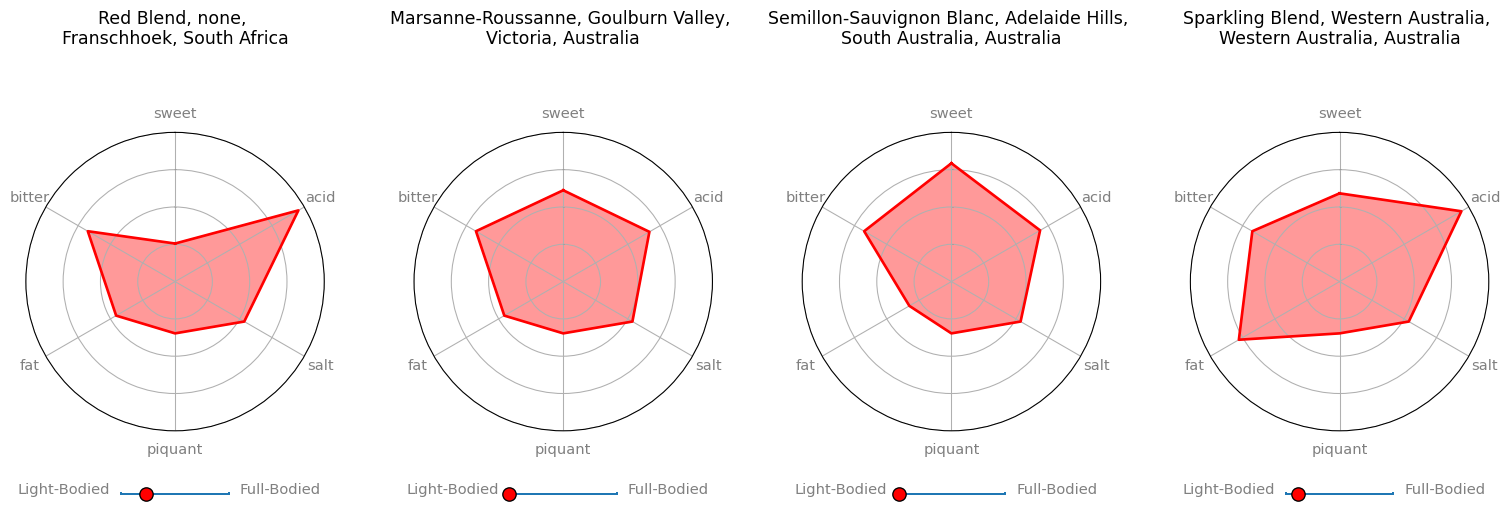

In [18]:
main(dessert)